# The Model Development

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES=True

## Looking at the data

# of cat imgs training: 416
# of fish imgs training: 375
['10002817_5944408634.jpg' '1010884970_1aa4af4701.jpg'
 '1011749488_b465af926a.jpg' '1015160097_c4103501de.jpg'
 '1020320535_13679b940e.jpg']
['100667576_69fda74c76.jpg' '1030154082_dd5461af43.jpg'
 '1095938485_80b11c5e6d.jpg' '1096801276_d33045c6f6.jpg'
 '1120165084_5ada8a9537.jpg']


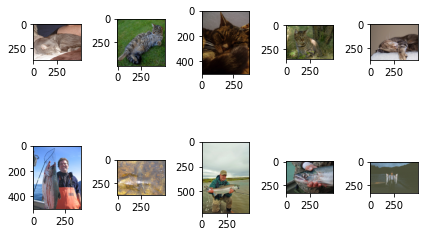

In [2]:
import os
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np

lst_of_cat_imgs = np.array(os.listdir("train\\cat"))
lst_of_fish_imgs = np.array(os.listdir("train\\fish"))
print(f"# of cat imgs training: {len(lst_of_cat_imgs)}")
print(f"# of fish imgs training: {len(lst_of_fish_imgs)}")

print(lst_of_cat_imgs[:5])
print(lst_of_fish_imgs[:5])

five_random_cat_imgs = np.random.choice(lst_of_cat_imgs, size=5, replace=False)
five_random_fish_imgs = np.random.choice(lst_of_fish_imgs, size=5, replace=False)

fig, ax = plt.subplots(nrows=2, ncols=5)

for i in range(5):
    ax[0,i].imshow(Image.open(f"train\\cat\\{five_random_cat_imgs[i]}"))
    ax[1,i].imshow(Image.open(f"train\\fish\\{five_random_fish_imgs[i]}"))

plt.tight_layout()
plt.show()

## Setting Up Datasets and Dataloaders

Calculate the mean and st. dev. for each of the dimensions.



We define the transforms for each image

In [3]:
img_transforms = transforms.Compose([
    transforms.Resize((64,64)),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225] )
    ])

In [4]:
train_data_path = "train"
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=img_transforms)

In [5]:
val_data_path = "val"
val_data = torchvision.datasets.ImageFolder(root=val_data_path,transform=img_transforms)

In [6]:
test_data_path = "test"
test_data = torchvision.datasets.ImageFolder(root=test_data_path,transform=img_transforms) 

In [7]:
batch_size=64

In [8]:
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size) 
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=batch_size) 

## Training

In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [10]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            input, target = batch
            output = model(input)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            
            training_loss += loss.data.item()
        training_loss /= len(train_loader)
    
        model.eval()
        num_correct = 0
        num_examples = 0
        for batch in val_loader:
            input, target = batch
            output = model(input)
            loss = loss_fn(output,target)

            valid_loss += loss.data.item()
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], target).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader)
        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch+1, training_loss, valid_loss, num_correct / num_examples))


### Define Model

First we create a simply fully connected neural network

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class Simplenn(nn.Module):

    def __init__(self) -> None:
        super(Simplenn, self).__init__()

        self.fc1 = nn.Linear(12288, 84)
        self.fc2 = nn.Linear(84, 50)
        self.fc3 = nn.Linear(50, 2)

    def forward(self, x):
        x = x.view(-1, 12288)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Second model to try is a CNN

In [12]:
class SimpleCNN(nn.Module):

    def __init__(self, num_classes=2) -> None:
        super(SimpleCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*6*6, 4096),
            nn.ReLU(),

            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),            

            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

Import pretrained ResNet

### Train Model

Training the simple fully connected neural net.

In [12]:
simple_model = Simplenn()
# simple_model.to(device)
optimizer = optim.Adam(simple_model.parameters(), lr=0.001)

train(simple_model, optimizer, torch.nn.CrossEntropyLoss(), 
        train_data_loader, val_data_loader, epochs=10, device=device)


C:\Users\victo\AppData\Local\Temp\ipykernel_20032\2818281110.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], target).view(-1)


Epoch: 1, Training Loss: 3.29, Validation Loss: 3.41, accuracy = 0.36
Epoch: 2, Training Loss: 2.37, Validation Loss: 1.73, accuracy = 0.67
Epoch: 3, Training Loss: 1.17, Validation Loss: 0.91, accuracy = 0.56
Epoch: 4, Training Loss: 0.62, Validation Loss: 0.75, accuracy = 0.70
Epoch: 5, Training Loss: 0.47, Validation Loss: 0.57, accuracy = 0.70
Epoch: 6, Training Loss: 0.32, Validation Loss: 0.67, accuracy = 0.71
Epoch: 7, Training Loss: 0.30, Validation Loss: 0.60, accuracy = 0.74
Epoch: 8, Training Loss: 0.24, Validation Loss: 0.61, accuracy = 0.75
Epoch: 9, Training Loss: 0.21, Validation Loss: 0.60, accuracy = 0.74
Epoch: 10, Training Loss: 0.18, Validation Loss: 0.60, accuracy = 0.76


Saving the model params

In [16]:
torch.save(simple_model.state_dict(), "tmp\\simple_model")

Training the CNN (AlexNet)

In [22]:
cnn_model = SimpleCNN()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

train(cnn_model, optimizer, torch.nn.CrossEntropyLoss(), 
        train_data_loader, val_data_loader, epochs=10, device=device)

C:\Users\victo\AppData\Local\Temp\ipykernel_20032\2818281110.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], target).view(-1)


Epoch: 1, Training Loss: 880.81, Validation Loss: 0.70, accuracy = 0.19
Epoch: 2, Training Loss: 1.01, Validation Loss: 0.76, accuracy = 0.19
Epoch: 3, Training Loss: 0.67, Validation Loss: 1.41, accuracy = 0.19
Epoch: 4, Training Loss: 0.89, Validation Loss: 0.71, accuracy = 0.19
Epoch: 5, Training Loss: 0.69, Validation Loss: 0.74, accuracy = 0.19
Epoch: 6, Training Loss: 0.72, Validation Loss: 0.70, accuracy = 0.19
Epoch: 7, Training Loss: 0.69, Validation Loss: 0.72, accuracy = 0.19
Epoch: 8, Training Loss: 0.54, Validation Loss: 15.08, accuracy = 0.19
Epoch: 9, Training Loss: 2.76, Validation Loss: 0.69, accuracy = 0.43
Epoch: 10, Training Loss: 0.70, Validation Loss: 0.69, accuracy = 0.81


Saving the model params

In [23]:
torch.save(cnn_model.state_dict(), "tmp\\cnn_model")

## Testing

In [19]:
def test(model, test_loader, loss_fn):
    model.eval()
    num_correct = 0
    num_examples = 0
    test_loss = 0.0
    for batch in test_loader:
        input, target = batch
        output = model(input)

        loss = loss_fn(output,target)
        test_loss += loss.data.item()

        correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], target).view(-1)
        num_correct += torch.sum(correct).item()
        num_examples += correct.shape[0]
    test_loss /= len(test_loader)
    print('Test Loss: {:.2f}, accuracy = {:.2f}'.format(test_loss, num_correct / num_examples))


### Test Model

Testing simple fully connected NN

In [20]:
test(simple_model, test_data_loader, torch.nn.CrossEntropyLoss())

C:\Users\victo\AppData\Local\Temp\ipykernel_20032\2163689587.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], target).view(-1)


Test Loss: 0.50, accuracy = 0.76


Testing CNN (AlexNet)

In [24]:
test(cnn_model, test_data_loader, torch.nn.CrossEntropyLoss())

C:\Users\victo\AppData\Local\Temp\ipykernel_20032\2163689587.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], target).view(-1)


Test Loss: 0.69, accuracy = 0.57
